[MIT License](https://github.com/cdslaborg/paramonte#license)  
[ParaMonte: plain powerful parallel Monte Carlo library](https://github.com/cdslaborg/paramonte).  
Copyright (C) 2012-present, [The Computational Data Science Lab](https://www.cdslab.org/#about)  
https://github.com/cdslaborg/paramonte  

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Running ParaDRAM simulations in parallel on multiple processors  

There are **two parallelism paradigms** currently implemented **in the ParaDRAM sampler**:

1. The **single-chain parallelism**, in which only a single Markov chain is generated, but all processors contribute to the construction of this chain.  
1. The **multi-chain parallelism**, in which each processor creates its Markov chain separately from the rest of the processors. However, at the end of the simulation, all processors communicate with each other to compute the probability that convergence to the target density has occurred and that all processors have sampled the same region of high probability in the domain of the objective function.  

### Which parallelism paradigm should be used when?

- The **single-chain parallelism** becomes very useful for large-scale problems that are highly computationally demanding.  
- The **multi-chain parallelism** is useful when you suspect that the target objective function that has to be sampled is multi-modal. In such cases, the multi-chain parallelism could provide further evidence on whether convergence to single-mode or multi-modal target density function has occurred or not.  
  
  
In either parallelism case, the ParaMonte library currently uses the MPI library for inter-process communications. As such, if you want to run a ParaDRAM simulation in parallel, you will have to first save your Python scripts in external Python files and then call them from the command line via the MPI launcher application.  
  

To see how this can be done, consider the simple toy problem of [sampling a 4-dimensional Multivariate Normal (MVN) distribution as described in this jupyter notebook](https://nbviewer.jupyter.org/github/cdslaborg/paramontex/blob/master/Python/Jupyter/sampling_multivariate_normal_density_function_via_paradram.ipynb).  

In [2]:
import paramonte as pm
pm.verify()


:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
::::                                                                                       ::::

       _/_/_/_/                                   _/_/    _/_/
        _/    _/                                  _/_/_/_/_/                     _/
       _/    _/ _/_/_/_/   _/ /_/_/ _/_/_/_/     _/  _/  _/   _/_/   _/_/_/   _/_/_/  _/_/_/
      _/_/_/   _/    _/   _/_/     _/    _/     _/      _/  _/   _/ _/    _/   _/   _/_/_/_/                        
     _/       _/    _/   _/       _/    _/     _/      _/  _/   _/ _/    _/   _/   _/    
  _/_/_/       _/_/_/_/ _/         _/_/_/_/ _/_/_/  _/_/_/  _/_/  _/    _/   _/_/   _/_/_/


                                          ParaMonte
                                   plain powerful parallel
                                     Monte Carlo library
                                        Version 2.0.6

::::                                       

## Running a single-chain ParaDRAM simulation in parallel on multiple processors

We will save our parallel script in a file with the same name as this Jupyter Notebook's name,  

In [3]:
with open("./sampling_multivariate_normal_density_function_via_paradram_parallel_singleChain.py","w") as file:
    contents = """
import numpy as np

NDIM = 4                                # number of dimensions of the domain of the MVN PDF
MEAN =  np.double([-10, 15., 20., 0.0]) # This is the mean of the MVN PDF.
COVMAT = np.double( [ [1.0,.45,-.3,0.0] # This is the covariance matrix of the MVN PDF.
                    , [.45,1.0,0.3,-.2]
                    , [-.3,0.3,1.0,0.6]
                    , [0.0,-.2,0.6,1.0]
                    ] )

INVCOV = np.linalg.inv(COVMAT) # This is the inverse of the covariance matrix of the MVN distribution.

# The following is the log of the coefficient used in the definition of the MVN.

MVN_COEF = NDIM * np.log( 1. / np.sqrt(2.*np.pi) ) + np.log( np.sqrt(np.linalg.det(INVCOV)) )

# the logarithm of objective function: log(MVN)

def getLogFunc(point):
    '''
    Return the logarithm of the MVN PDF.
    '''
    normedPoint = MEAN - point
    return MVN_COEF - 0.5 * ( np.dot(normedPoint,np.matmul(INVCOV,normedPoint)) )

import paramonte as pm

pmpd = pm.ParaDRAM() # define a ParaMonte sampler instance

pmpd.mpiEnabled = True # This is essential as it enables the invocation of the MPI-parallelized ParaDRAM routines.

pmpd.spec.randomSeed = 3751 # initialize the random seed to generate reproducible results.
pmpd.spec.outputFileName = "./sampling_multivariate_normal_density_function_via_paradram/mvn_parallel_singleChain"
pmpd.spec.progressReportPeriod = 20000
pmpd.spec.chainSize = 30000 # the default 100,000 unique points is too large for this simple example.

# call the ParaDRAM sampler

pmpd.runSampler ( ndim = 4
                , getLogFunc = getLogFunc
                )
"""
    file.write(contents)

Here is the saved [output MPI-parallelized Python script](./sampling_multivariate_normal_density_function_via_paradram_parallel_singleChain.py).
> **Note** the only difference in the above parallel script with the serial version, which is the extra Python statement `pmpd.mpiEnabled = True`. This flag tells the ParaDRAM sampler initiate the simulation in parallel and silence all output messages that would otherwise be printed by all processes.  .

**IMPORTANT**: At this point, we have assumed that you already have an MPI runtime library installed on your system. We highly recommend the use of the Intel MPI library on your system if it is Windows or Linux, and Open-MPI if it is macOS. You can run `pm.verify()` on your python command line, just as described in the Jupyter notebook for the serial sampling of the MVN distribution, to verify the existence of the MPI library on your system.

We will now run this code in parallel on 3 processors. We will invoke the `mpiexe` launcher to run the code in parallel, however, depending on your system, your platform, or the supercomputer on which you are running this code, you may need a different MPI launcher (e.g., `ibrun`, `mpirun`, ...). In the following, we will assume that you will be using the Intel MPI library if your operating system is Windows (as implied by the flag `-localonly`).  

Now, we run the MPI-enabled Python script in parallel on three cores, **on the terminal** (not in the Python session). On Linux or macOS, we can try the following command,  
```bash  
mpiexec -n 3 python main_mpi_singleChain.py
```  

On windows, if you are using the Intel MPI library, we can try the following,  
```batch  
mpiexec -localonly -n 3 python main_mpi_singleChain.py
```  
Otherwise, the same syntax and flags as used in the cases of Linux and macOS should work fine. To understand the meaning of the extra `-localonly` flag, see the [ParaMonte library documentation page](https://www.cdslab.org/paramonte/notes/run/python/#running-python-simulations-on-the-command-prompt-on-multiple-processors).  

The following command combines the above two commands in a single line so that it works, whether you are using a Windows machine or Linux/macOS,

In [4]:
!ls && \
mpiexec -n 3 python sampling_multivariate_normal_density_function_via_paradram_parallel_singleChain.py || \
mpiexec -localonly -n 3 python sampling_multivariate_normal_density_function_via_paradram_parallel_singleChain.py

 
************************************************************************************************************************************
************************************************************************************************************************************
****                                                                                                                            ****
****                                                                                                                            ****
****                                                         ParaMonte                                                          ****
****                                                  Plain Powerful Parallel                                                   ****
****                                                    Monte Carlo Library                                                     ****
****                                                               

'ls' is not recognized as an internal or external command,
operable program or batch file.
Abort(1) on node 2 (rank 2 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 1) - process 2
Abort(1) on node 1 (rank 1 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 1) - process 1
Abort(1) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 1) - process 0


The sampler has now generated 5 output files that are [accessible here](sampling_multivariate_normal_density_function_via_paradram/), all prefixed with `mvn_parallel_singleChain_*`. In particular, the [simulation report file](sampling_multivariate_normal_density_function_via_paradram/mvn_parallel_singleChain_process_1_report.txt) contains a lot of interesting information about the performance of the parallel simulation. We can process these files in the same way we did for [the serial version of sampling the MVN PDF via the ParaDRAM sampler](https://nbviewer.jupyter.org/github/cdslaborg/paramontex/blob/master/Python/Jupyter/sampling_multivariate_normal_density_function_via_paradram.ipynb). For example, to parse the contents of the report file, we can try,  

In [5]:
import paramonte as pm
print(pm.version.interface.get())
print(pm.version.kernel.get())

pmpd = pm.ParaDRAM()
pmpd.readReport("./sampling_multivariate_normal_density_function_via_paradram/mvn_parallel_singleChain")
report = pmpd.reportList[0]

ParaMonte Python Interface Version 2.0.6
ParaMonte Python Kernel Version 1.2.0

ParaDRAM - NOTE: 1 files detected matching the pattern: "./sampling_multivariate_normal_density_function_via_paradram/mvn_parallel_singleChain*_report.txt"


ParaDRAM - NOTE: processing report file: D:\Dropbox\Projects\20180101_ParaMonte\paramontex\Python\Jupyter\sampling_multivariate_normal_density_function_via_paradram\mvn_parallel_singleChain_process_1_report.txt
ParaDRAM - NOTE: reading the file contents... ParaDRAM - NOTE: parsing the report file contents...
done in 0.005165 seconds.

ParaDRAM - NOTE: The processed report files are now stored in the newly-created
ParaDRAM - NOTE: component `reportList` of the ParaDRAM object as a Python list.
ParaDRAM - NOTE: For example, to access the entire contents of the first (or the only) report file, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.reportList[0].contents.print()
ParaDRAM - NOTE: 
ParaDRAM - NOTE: where you will have to replace `pmpd` with your P

There are a lot of detailed information about different aspects of the parallel simulation in this file. Here is a glance through some of the information extracted from the file,  

In [6]:
print(report.stats.time.perFuncCall.value)
print(report.stats.time.perFuncCall.description)

1.217706483180924e-05
This is the average pure time cost of each function call, in seconds.


In [7]:
print(report.stats.time.perInterProcessCommunication.value)
print(report.stats.time.perInterProcessCommunication.description)

1.903849622046255e-06
This is the average time cost of inter-process communications per used (accepted or rejected or delayed-rejection) function call, in seconds.


In [8]:
print(report.stats.parallelism.current.numProcess.value)
print(report.stats.parallelism.current.numProcess.description)

3
This is the number of processes (images) used in this simulation.


In [9]:
print(report.stats.parallelism.current.speedup.value)
print(report.stats.parallelism.current.speedup.description)

1.624412880350936
This is the estimated maximum speedup gained via singleChain parallelization model compared to serial mode.


In [10]:
print(report.stats.parallelism.optimal.current.speedup.value)
print(report.stats.parallelism.optimal.current.speedup.description)

1.624412880350936
This is the predicted optimal maximum speedup gained via singleChain parallelization model, given the current MCMC sampling efficiency.


In [11]:
print(report.stats.parallelism.optimal.absolute.speedup.value)
print(report.stats.parallelism.optimal.absolute.speedup.description)

2.063895076740411
This is the predicted absolute optimal maximum speedup gained via singleChain parallelization model, under any MCMC sampling efficiency. This simulation will likely NOT benefit from any additional computing processors beyond the predicted absolute optimal number, 4, in the above. This is true for any value of MCMC sampling efficiency. Keep in mind that the predicted absolute optimal number of processors is just an estimate whose accuracy depends on many runtime factors, including the topology of the communication network being used, the number of processors per node, and the number of tasks to each processor or node.


In [12]:
print(report.stats.parallelism.processContribution.value)
print(report.stats.parallelism.processContribution.description)

[13792, 9551, 6657]
These are contributions of individual processes to the construction of the MCMC chain. Essentially, they represent the total number of accepted states by the corresponding processor, starting from the first processor to the last. This information is mostly informative in parallel Fork-Join (singleChain) simulations.


The ParaDRAM sampler also automatically computes the strong scaling behavior of the parallel simulation under the current and absolutely optimal simulation conditions. For example, we can plot these scaling results like the following,  

In [13]:
print(report.stats.parallelism.optimal.current.scaling.strong.speedup.value)
print(report.stats.parallelism.optimal.current.scaling.strong.speedup.description)

[1.0, 1.4964846, 1.6244129, 1.5810499, 1.4773289, 1.3609203]
This is the predicted strong-scaling speedup behavior of the singleChain parallelization model, given the current MCMC sampling efficiency, for increasing numbers of processes, starting from a single process.


In [14]:
print(report.stats.parallelism.optimal.absolute.scaling.strong.speedup.value)
print(report.stats.parallelism.optimal.absolute.scaling.strong.speedup.description)

[1.0, 1.7295844, 2.0421479, 2.0638951, 1.9504799, 1.7936107]
This is the predicted absolute strong-scaling speedup behavior of the singleChain parallelization model, under any MCMC sampling efficiency, for increasing numbers of processes, starting from a single process.


<IPython.core.display.Javascript object>


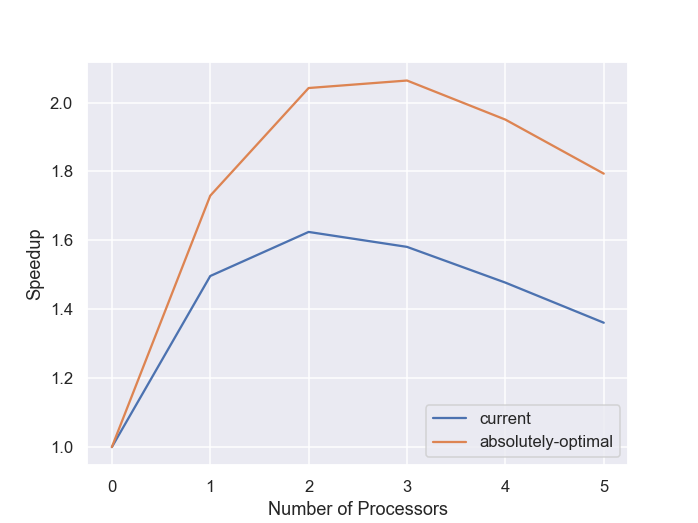

In [15]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
fig = plt.figure()
ax = fig.gca()
ax.plot(report.stats.parallelism.optimal.current.scaling.strong.speedup.value)
ax.plot(report.stats.parallelism.optimal.absolute.scaling.strong.speedup.value)
ax.set_ylabel("Speedup")
ax.set_xlabel("Number of Processors")
ax.legend(labels = ["current","absolutely-optimal"])

### The efficiency of the parallel simulation  

As we see in the above plot and the information extracted from the report file, the **Estimated maximum speedup gained via singleChain parallelization model compared to serial mode**, was only moderate (less than twice). This is partly because the example objective function here is too easy to compute and partly because this simulation was performed on a decent fast quad-core processor.  

But, more importantly, note the **Predicted absolute optimal maximum speedup** gained via singleChain parallelization model, **under any MCMC sampling efficiency**, which tells us that no matter how you configure this simulation, the speedup gained by running this simulation in parallel can be **at most** a factor of ~2 better than the performance of the serial run of the same problem with the same simulation specifications, **regardless of how many CPU cores you may use for the parallel simulation**.  

**The ability of the sampler to give us such detailed efficiency reports is remarkable as it can help us set up our parallel simulations more reasonably and optimally, without wasting any extra computational resources with no efficiency gain**.

> When you are working with expensive large-scale simulations, it is, therefore, a good idea to run some tests of your simulation and check the output of the report file to find the predicted optimal number of physical cores for the parallel simulation and then, request the same number of cores as predicted when invoking the MPI launcher.  

Similar to the report file, the rest of the simulation data can be also parsed and analyzed. However, such tasks are identical to the case of the serial simulation and we, therefore, suffice to direct the reader of this notebook to [the Jupyter notebook for the serial version of this simulation problem](https://nbviewer.jupyter.org/github/cdslaborg/paramontex/blob/master/Python/Jupyter/sampling_multivariate_normal_density_function_via_paradram.ipynb).  

## Running a multi-chain ParaDRAM simulation in parallel on multiple processors  

There is another mode of parallelization, the **multiChain** or **multi-chain** mode, by which the ParaDRAM sampler can sample points from the objective function. In this mode, the sampler will generate multiple chains, each corresponding to one physical core on the computer. Each of these chains will independently explore the domain of the objective function.  

To make the exploration even more interesting and robust (i.e., to ensure convergence to the target objective function by all independent chains), we can also let the initial starting point of the MCMC sampler to be chosen at random. To do so, we will have to also specify a domain from which the initial random start points will be sampled, otherwise, the default domain extends from negative infinity to positive infinity, which is problematic for computer simulations,  

In [16]:
with open("./sampling_multivariate_normal_density_function_via_paradram_parallel_multiChain.py","w") as file:
    contents = """
import numpy as np

NDIM = 4                                # number of dimensions of the domain of the MVN PDF
MEAN =  np.double([-10, 15., 20., 0.0]) # This is the mean of the MVN PDF.
COVMAT = np.double( [ [1.0,.45,-.3,0.0] # This is the covariance matrix of the MVN PDF.
                    , [.45,1.0,0.3,-.2]
                    , [-.3,0.3,1.0,0.6]
                    , [0.0,-.2,0.6,1.0]
                    ] )

INVCOV = np.linalg.inv(COVMAT) # This is the inverse of the covariance matrix of the MVN distribution.

# The following is the log of the coefficient used in the definition of the MVN.

MVN_COEF = NDIM * np.log( 1. / np.sqrt(2.*np.pi) ) + np.log( np.sqrt(np.linalg.det(INVCOV)) )

# the logarithm of objective function: log(MVN)

def getLogFunc(point):
    '''
    Return the logarithm of the MVN PDF.
    '''
    normedPoint = MEAN - point
    return MVN_COEF - 0.5 * ( np.dot(normedPoint,np.matmul(INVCOV,normedPoint)) )

import paramonte as pm

pmpd = pm.ParaDRAM() # define a ParaMonte sampler instance

pmpd.mpiEnabled = True # This is essential as it enables the invocation of the MPI-parallelized ParaDRAM routines.

pmpd.spec.randomSeed = 3751 # initialize the random seed to generate reproducible results.
pmpd.spec.outputFileName = "./sampling_multivariate_normal_density_function_via_paradram/mvn_parallel_multiChain"
pmpd.spec.progressReportPeriod = 20000
pmpd.spec.chainSize = 30000 # the default 100,000 unique points is too large for this simple example, so set it to 30000.

# set up a random initial starting point for each of the independent MCMC chains,
# by defining the domain of the random start points. The following defines the 
# boundaries of the NDIM(=four)-dimensional hypercube from within which the 
# random initial start points will be drawn by the sampler,

pmpd.spec.randomStartPointRequested = True # This is essential, otherwise, random initialization won't happen
pmpd.spec.randomStartPointDomainLowerLimitVec = NDIM * [-25]
pmpd.spec.randomStartPointDomainUpperLimitVec = NDIM * [+25]

# set the parallelization model to multichain

pmpd.spec.parallelizationModel = "multi chain" # the value is case and white-space insensitive

# call the ParaDRAM sampler

pmpd.runSampler ( ndim = 4
                , getLogFunc = getLogFunc
                )
"""
    file.write(contents)

Now, we run the MPI-enabled Python script in parallel on three cores, **on the terminal** (not in the Python session),  

In [17]:
!ls && \
mpiexec -n 3 python sampling_multivariate_normal_density_function_via_paradram_parallel_multiChain.py || \
mpiexec -localonly -n 3 python sampling_multivariate_normal_density_function_via_paradram_parallel_multiChain.py

 
************************************************************************************************************************************
************************************************************************************************************************************
****                                                                                                                            ****
****                                                                                                                            ****
****                                                         ParaMonte                                                          ****
****                                                  Plain Powerful Parallel                                                   ****
****                                                    Monte Carlo Library                                                     ****
****                                                               

'ls' is not recognized as an internal or external command,
operable program or batch file.


Unlike the the other modes of simulation, wether serial or `singleChain`-parallel, the `multiChain`-parallel ParadRAM simulation generates `5 * number_of_cores` [output files (prefixed by `mvn_parallel_multiChain*`)](sampling_multivariate_normal_density_function_via_paradram/) on the system, separated from each other by their processor IDs (starting from 1).  

#### The Kolmogorov-Smirnov test of similarity of the independent samples from the independent MCMC chains

By looking at the end of any of the output `_report.txt` files, we will notice that the Kolmogorov-Smirnov (KS) probabilities of the similarities of pairs of these independent samples from indepedent MCMC chains is generally quite high, indicating the high level of similarities between the independent samples obtained from the independent MCMC chains. **This means that there is no evidence of the lack of convergence of the MCMC samples to the target objective function**. We know this for sure in this particular example, because the structure of the objective function is known to us. In other problems, however, this may never be known, in other words, *we can just hope that the convergence has occurred*.

Here is a KS-probability-table excerpt from the first processor's output `*_report.txt` file,

In [18]:
import paramonte as pm
print(pm.version.interface.get())
print(pm.version.kernel.get())

pmpd = pm.ParaDRAM()
report = pmpd.readReport( "./sampling_multivariate_normal_density_function_via_paradram/mvn_parallel_multiChain"
                        , renabled = True
                        )[0] # keep only the first report file's contents

ParaMonte Python Interface Version 2.0.6
ParaMonte Python Kernel Version 1.2.0

ParaDRAM - NOTE: 3 files detected matching the pattern: "./sampling_multivariate_normal_density_function_via_paradram/mvn_parallel_multiChain*_report.txt"


ParaDRAM - NOTE: processing report file: D:\Dropbox\Projects\20180101_ParaMonte\paramontex\Python\Jupyter\sampling_multivariate_normal_density_function_via_paradram\mvn_parallel_multiChain_process_1_report.txt
ParaDRAM - NOTE: reading the file contents... ParaDRAM - NOTE: parsing the report file contents...
done in 0.015118 seconds.

ParaDRAM - NOTE: processing report file: D:\Dropbox\Projects\20180101_ParaMonte\paramontex\Python\Jupyter\sampling_multivariate_normal_density_function_via_paradram\mvn_parallel_multiChain_process_2_report.txt
ParaDRAM - NOTE: reading the file contents... ParaDRAM - NOTE: parsing the report file contents...
done in 0.0 seconds.

ParaDRAM - NOTE: processing report file: D:\Dropbox\Projects\20180101_ParaMonte\paramontex\Pytho

In [19]:
print(report.stats.chain.refined.kstest.prob.value)
print(report.stats.chain.refined.kstest.prob.description)

                       ProcessID   probKS(SampleLogFunc) probKS(SampleVariable1) probKS(SampleVariable2) probKS(SampleVariable3) probKS(SampleVariable4)                        2         0.90685077E+000         0.27098219E+000         0.24814997E-001         0.91099522E+000         0.81935233E+000                        3         0.84756173E+000         0.98182882E-001         0.47256591E+000         0.70724914E+000         0.78006492E+000 
This is the table pairwise inter-chain Kolmogorov-Smirnov (KS) convergence (similarity) probabilities. Higher KS probabilities are better, indicating less evidence for a lack of convergence.


We can also read and visualize the results of these parallel runs just as before,

In [20]:
%matplotlib notebook
import paramonte as pm
pmpd = pm.ParaDRAM()
markov = pmpd.readMarkovChain( "./sampling_multivariate_normal_density_function_via_paradram/mvn_parallel_multiChain_*"
                             , renabled = True
                             )[0] # keep only the first file contents' object


ParaDRAM - WARNING: The ``delimiter`` is neither given as input to ``readMarkovchain()``
ParaDRAM - WARNING: nor set as a simulation specification of the ParaDRAM object. 
ParaDRAM - WARNING: This information is essential, otherwise how could the output files be parsed?
ParaDRAM - WARNING: For now, the ParaDRAM sampler will assume a comma-separated 
ParaDRAM - WARNING: file format for the contents of the chain file(s) to be parsed.


ParaDRAM - NOTE: 3 files detected matching the pattern: "./sampling_multivariate_normal_density_function_via_paradram/mvn_parallel_multiChain_*_chain.txt"


ParaDRAM - NOTE: processing chain file: D:\Dropbox\Projects\20180101_ParaMonte\paramontex\Python\Jupyter\sampling_multivariate_normal_density_function_via_paradram\mvn_parallel_multiChain_process_1_chain.txt
ParaDRAM - NOTE: reading the file contents... done in 3.610332 seconds.
ParaDRAM - NOTE: ndim = 4, count = 128508
ParaDRAM - NOTE: parsing file contents... 
ParaDRAM - NOTE: computing the sample c

ParaDRAM - NOTE: making the line plot... 

<IPython.core.display.Javascript object>


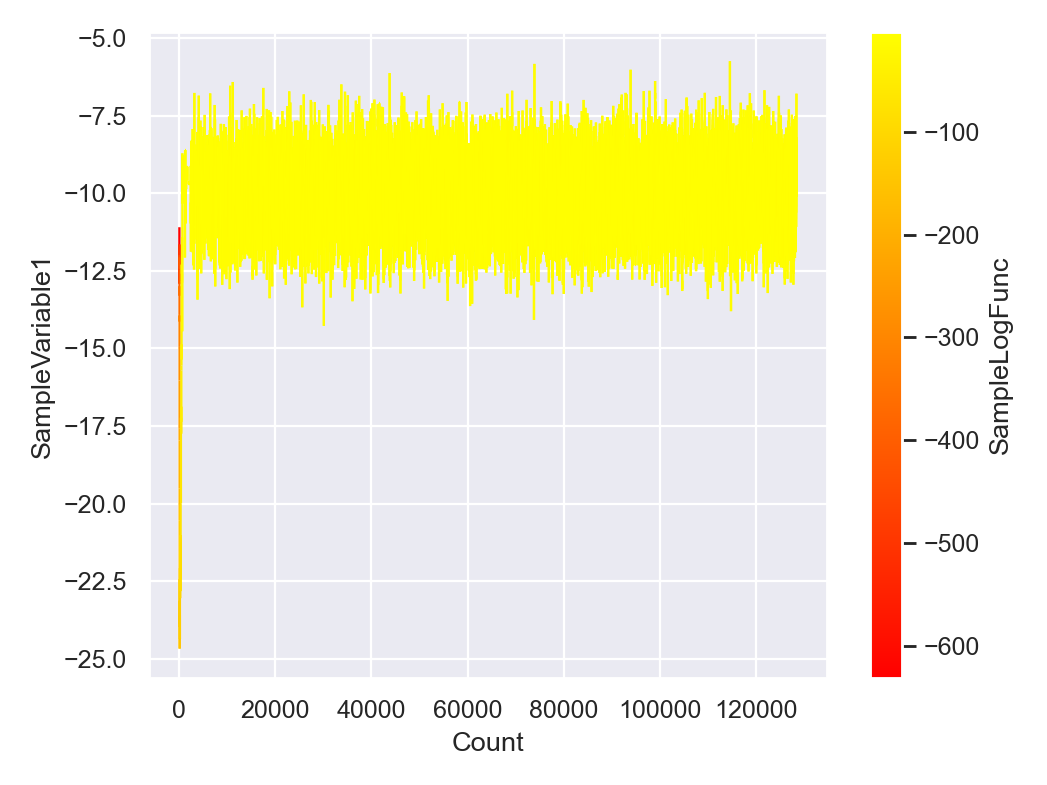

done in 1.259705 seconds.


In [21]:
markov.plot.line()

Let's take the log of the x-axis for better visualization,

ParaDRAM - NOTE: making the line plot... 

<IPython.core.display.Javascript object>


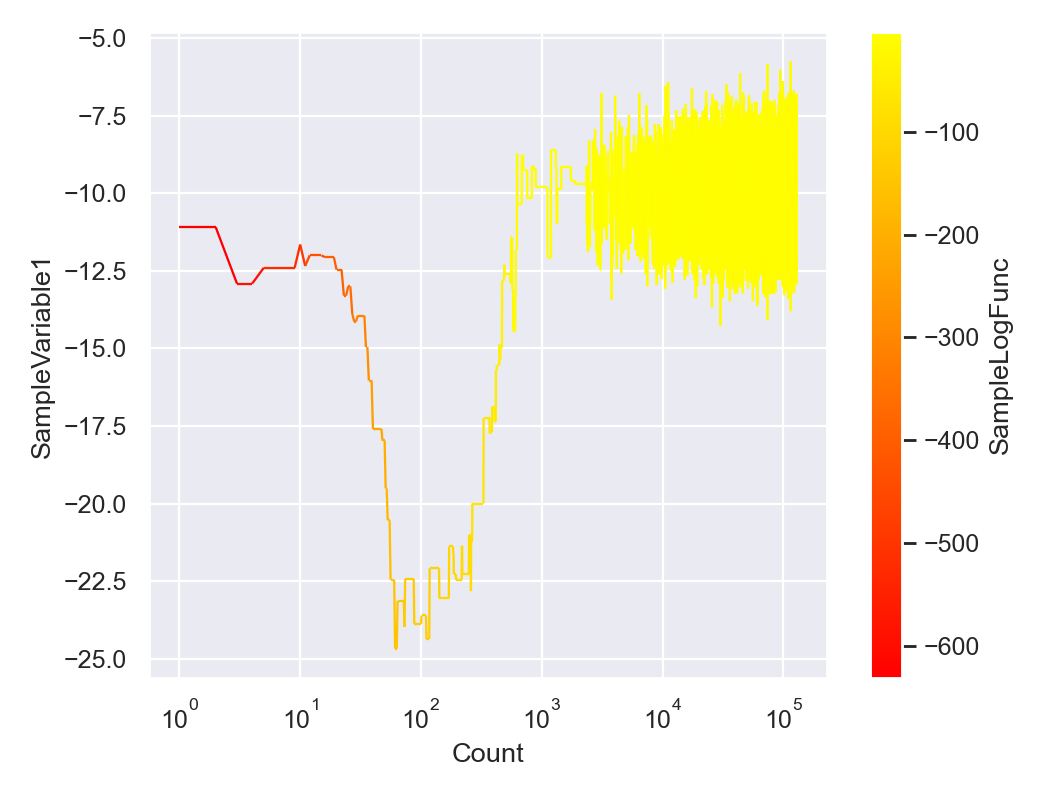

done in 1.180152 seconds.


In [22]:
markov.plot.line()
markov.plot.line.currentFig.axes.set_xscale("log")

We can compare this plot with the resulting Markov chain from, say, processor #3,

ParaDRAM - NOTE: making the line plot... 

<IPython.core.display.Javascript object>


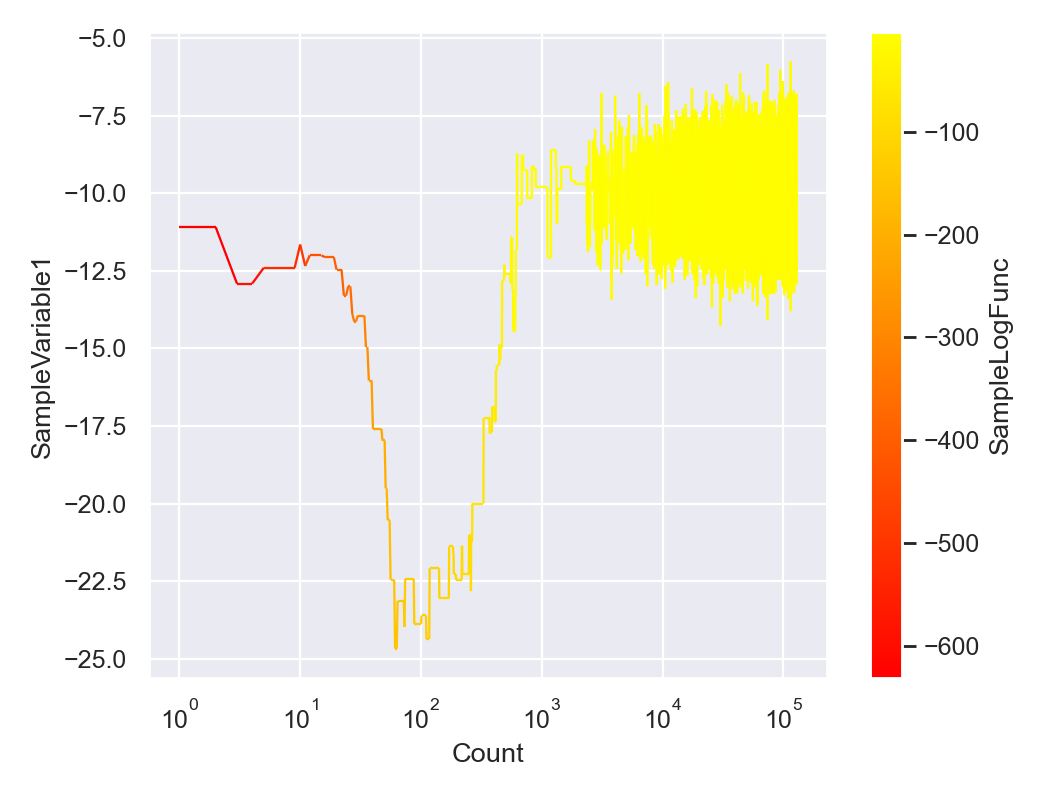

done in 1.185061 seconds.


In [23]:
markov.plot.line()
markov.plot.line.currentFig.axes.set_xscale("log")

Or perhaps, compare all of the independent (compact) chains (of uniquely sampled points) on the same plot,  


ParaDRAM - NOTE: 3 files detected matching the pattern: "./sampling_multivariate_normal_density_function_via_paradram/mvn_parallel_multiChain*_report.txt"


ParaDRAM - NOTE: processing report file: D:\Dropbox\Projects\20180101_ParaMonte\paramontex\Python\Jupyter\sampling_multivariate_normal_density_function_via_paradram\mvn_parallel_multiChain_process_1_report.txt
ParaDRAM - NOTE: reading the file contents... ParaDRAM - NOTE: parsing the report file contents...
done in 0.005039 seconds.

ParaDRAM - NOTE: processing report file: D:\Dropbox\Projects\20180101_ParaMonte\paramontex\Python\Jupyter\sampling_multivariate_normal_density_function_via_paradram\mvn_parallel_multiChain_process_2_report.txt
ParaDRAM - NOTE: reading the file contents... ParaDRAM - NOTE: parsing the report file contents...
done in 0.014908 seconds.

ParaDRAM - NOTE: processing report file: D:\Dropbox\Projects\20180101_ParaMonte\paramontex\Python\Jupyter\sampling_multivariate_normal_density_function_via_paradram\mvn_p

ParaDRAM - NOTE: adding the graphics tools... 
ParaDRAM - NOTE: creating a line plot object from scratch... done in 0.0 seconds.
ParaDRAM - NOTE: creating a scatter plot object from scratch... done in 0.0 seconds.
ParaDRAM - NOTE: creating a lineScatter plot object from scratch... done in 0.0 seconds.
ParaDRAM - NOTE: creating a line3 plot object from scratch... done in 0.0 seconds.
ParaDRAM - NOTE: creating a scatter3 plot object from scratch... done in 0.0 seconds.
ParaDRAM - NOTE: creating a lineScatter3 plot object from scratch... done in 0.0 seconds.
ParaDRAM - NOTE: creating a jointplot plot object from scratch... done in 0.0 seconds.
ParaDRAM - NOTE: creating a histplot plot object from scratch... done in 0.0 seconds.
ParaDRAM - NOTE: creating a kdeplot1 plot object from scratch... done in 0.0 seconds.
ParaDRAM - NOTE: creating a kdeplot2 plot object from scratch... done in 0.0 seconds.
ParaDRAM - NOTE: creating a contour3 plot object from scratch... done in 0.0 seconds.
ParaDRA

<IPython.core.display.Javascript object>


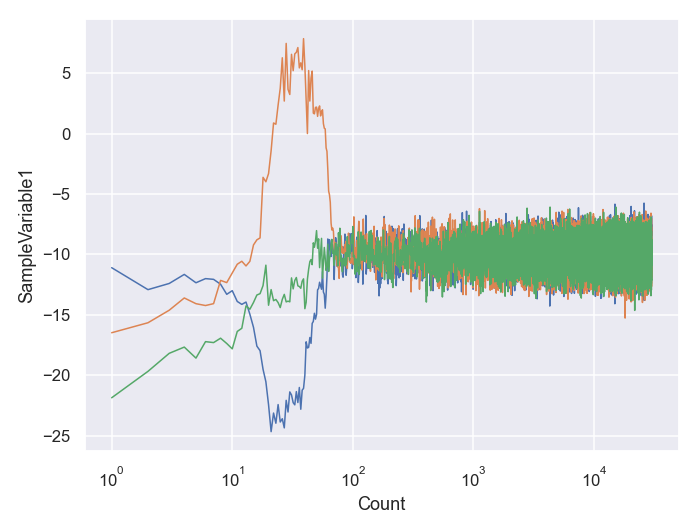

ParaDRAM - NOTE: making the line plot... done in 0.092222 seconds.
ParaDRAM - NOTE: making the line plot... done in 0.03792 seconds.
ParaDRAM - NOTE: making the line plot... done in 0.039901 seconds.


In [24]:
import matplotlib.pyplot as plt
import paramonte as pm
pmpd = pm.ParaDRAM()
pmpd.readReport("./sampling_multivariate_normal_density_function_via_paradram/mvn_parallel_multiChain")
pmpd.readChain("./sampling_multivariate_normal_density_function_via_paradram/mvn_parallel_multiChain")

plt.figure() # one figure for all plots

for process in range(pmpd.reportList[0].stats.parallelism.current.numProcess.value):

    pmpd.chainList[process].plot.line.figure.enabled = False # all plots appear in the same plot
    pmpd.chainList[process].plot.line.ccolumns = None # turn off color-mapping
    pmpd.chainList[process].plot.line()

pmpd.chainList[process].plot.line.currentFig.axes.set_xscale("log")

Impressively, all independent chains, even though all start at random locations in the domain of the objective function, end up at the same sole peak of the objective function, as expected and illustrated in the above figure.

>**There are many more functionalities and features of the ParaMonte library that were neither explored nor mentioned in this example Jupyter notebook. You can explore them by checking the existing components of each attribute of the ParaDRAM sampler class and by visiting the [ParaMonte library's documentation website](http://cdslab.org/paramonte/)**.